# Model evaluation using Sidekick

Use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [1]:
from IPython.display import display, Image
import os
import operator
import sidekick
import resource
import itertools
import pandas as pd
from glob import glob
from PIL import Image

## Setup

### Paths

In [2]:
#preprocessed dataset
dataset_path = 'fruits-360/Test'
os.chdir(dataset_path)

### Client to deployment

In [3]:
#Update the URL and token
client = sidekick.Deployment(
    # Enter URL and token
    url='https://...',
    token='...',
    dtypes_in={'image': 'Image (100x100x3)'},
    dtypes_out={'class': 'Categorical (103)'}
)

### Helper functions

In [4]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)

In [5]:
def get_image(path):
    im = Image.open(path)
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

## Create test dataframe - ground truth

In [6]:
images_rel_path = glob(os.path.join('*', '*.jpg')) + glob(os.path.join('*', '*.png'))
print("Images found: ", len(images_rel_path))

Images found:  17845


In [7]:
df = pd.DataFrame({'image': images_rel_path})
df['class'] = df['image'].apply(lambda path: os.path.basename(os.path.dirname(path)))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,class
0,Grape White 3/163_100.jpg,Grape White 3
1,Carambula/146_100.jpg,Carambula
2,Apple Red Yellow 2/r2_191_100.jpg,Apple Red Yellow 2
3,Melon Piel de Sapo/r_18_100.jpg,Melon Piel de Sapo
4,Apple Red Yellow 1/86_100.jpg,Apple Red Yellow 1


## Single  predictions

In [8]:
im_path_list = iter(list(df['image']))

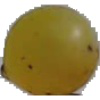

('Grape White 3', 0.9999132)


In [9]:
im_path = next(im_path_list)
im = Image.open(im_path)
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

## Multiple predictions

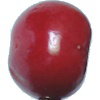

Ground truth: Cherry 2
Prediction: Cherry 2


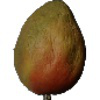

Ground truth: Papaya
Prediction: Papaya


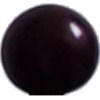

Ground truth: Cherry Wax Black
Prediction: Cherry Wax Black


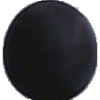

Ground truth: Grape Blue
Prediction: Grape Blue


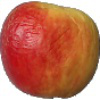

Ground truth: Apple Red Yellow 1
Prediction: Tangelo


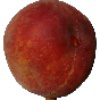

Ground truth: Peach
Prediction: Apple Red 1


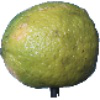

Ground truth: Limes
Prediction: Limes


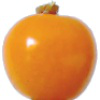

Ground truth: Physalis
Prediction: Physalis


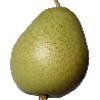

Ground truth: Pear
Prediction: Pear


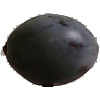

Ground truth: Plum 3
Prediction: Plum 3


In [10]:
rows = df.sample(n=10)
for i, row in rows.iterrows():
    im = Image.open(row['image'])    
    display(im)
    pred = client.predict(image=im)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], get_max_score(pred)[0]))

## Worst misclassified

Copy the image URLs to a new column.
Create a new column that contains the actual images.

In [11]:
eval_df = df.copy()
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))

Get all the predictions, this will take several minutes.
Store the predictions in a new column.

(This may take several minutes)

In [12]:
preds = [p for p in predictions]
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(5)

,image,class,image_url,pred
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Grape White 3,Grape White 3/163_100.jpg,"{'Apple Granny Smith': 4.0165405e-13, 'Grapefr..."
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Carambula,Carambula/146_100.jpg,"{'Apple Granny Smith': 2.0003577e-10, 'Grapefr..."
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Red Yellow 2,Apple Red Yellow 2/r2_191_100.jpg,"{'Apple Granny Smith': 5.8013443e-09, 'Grapefr..."
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Melon Piel de Sapo,Melon Piel de Sapo/r_18_100.jpg,"{'Apple Granny Smith': 1.7476738e-08, 'Grapefr..."
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Red Yellow 1,Apple Red Yellow 1/86_100.jpg,"{'Apple Granny Smith': 3.7865913e-18, 'Grapefr..."


Create new columns that contain the name of highest scoring class and the score.

In [42]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(5)

,image,class,image_url,pred,pred_class,pred_score
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Tomato 4,Tomato 4/r_2_100.jpg,"{'Apple Granny Smith': 3.579145e-15, 'Grapefru...",Tomato 2,0.555017
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Banana,Banana/87_100.jpg,"{'Apple Granny Smith': 1.2353572e-16, 'Grapefr...",Banana,0.998448
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Huckleberry,Huckleberry/189_100.jpg,"{'Apple Granny Smith': 2.5808186e-08, 'Grapefr...",Huckleberry,0.998519
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Kumquats,Kumquats/r_134_100.jpg,"{'Apple Granny Smith': 9.844162e-20, 'Grapefru...",Kumquats,0.997144
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Tomato 2,Tomato 2/r2_305_100.jpg,"{'Apple Granny Smith': 5.6125835e-15, 'Grapefr...",Tomato 2,0.966960


Get the top-ten samples with the highest prediction score and incorrect label.

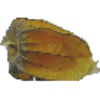

Ground truth: Physalis with Husk, Prediction: Banana, Score: 0.9997094


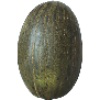

Ground truth: Melon Piel de Sapo, Prediction: Avocado ripe, Score: 0.99910694


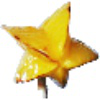

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.99893266


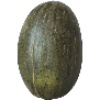

Ground truth: Melon Piel de Sapo, Prediction: Avocado ripe, Score: 0.998852


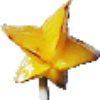

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.9988085


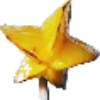

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.99876595


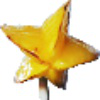

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.9987501


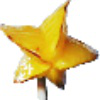

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.9986141


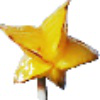

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.99838114


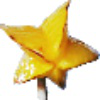

Ground truth: Carambula, Prediction: Banana Lady Finger, Score: 0.9983296


In [43]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))